# IRC belief to neural data 

Using IRC, we infered monkey's belief from their behavior.
We can then fit the neural acitivty to the behavioral inferred belief, to see the benifit of using IRC.


version 2: remove the neurons that fit to states (belief mu). 
the rest of neurons are solely fit to uncertainty.

In [3]:
# imports
import sys
import os
os.chdir('/workspaces/ffsb/test/neural')
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
os.chdir('/workspaces/ffsb')

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import scipy.interpolate as interpolate
import random
from sklearn.metrics import mean_squared_error, r2_score
from plot_ult import *
import configparser
from sklearn import linear_model
from pathlib import Path
from notification import notify
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from stable_baselines3 import TD3
import time
from torch.distributions.multivariate_normal import MultivariateNormal
import heapq
import warnings
import matplotlib.pyplot as plt
import copy
from cmaes import CMA
from numpy.lib.npyio import save
import pandas as pd
import pickle
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime
from copy import deepcopy
from firefly_utils.lfp_class import lfp_class
from firefly_utils.behav_class import *
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.data_handler import data_handler
from matplotlib import pyplot as plt
from numpy import pi
from sklearn.cross_decomposition import CCA
import torch
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score


## Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [4]:
# load neural data

config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir=config['Datafolder']['data']
resdir = Path(resdir)


dat = loadmat(resdir/'neuraltest/m53s31.mat') # this is a example session with good recording, more neurons
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key, 
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur,extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ=dict_to_vec(exp_data.behav.events.t_targ)
t_start=t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel','ang_vel','x_monk','y_monk', 'eye_hori', 'eye_vert','x_fly_screen','z_fly_screen','x_eye_screen','z_eye_screen',"x_fly_rel","y_fly_rel","ang_vel"
y,X,trial_idx = exp_data.concatenate_inputs(*var_names,t_start=t_start,t_stop=t_stop, time_stamps=ts)

trials=np.unique(trial_idx)
yes=0
total=0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx==trials[itrial]])<1:
        continue
    d=(X['x_fly_rel'][trial_idx==trials[itrial]][-1]**2 + X['y_fly_rel'][trial_idx==trials[itrial]][-1]**2)**0.5
    if d < 65: yes+=1
    total+=1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [5]:
brainarea=dat['units']['brain_area']


In [6]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0223newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
s = np.vstack([v for v in X.values()])
s = s.T


In [7]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

# with initiate_plot(3, 2, 200) as f:
#     ax = f.add_subplot(111)
#     plt.plot(bX)
#     plt.title('B-spline kernel')
#     quickspine(ax)
#     plt.xticks([0, kernel_len-1])
#     ax.set_xticklabels([-kernel_len*50, kernel_len*50])
#     plt.xlabel('time, ms')
#     plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [8]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

# Fitting the belief uncertainty

in this model, we use self centric (rotated according to heading direction) covariance matrix ((2,2) for position x,y) as the summary statistics for uncertainty.
if brain encodes uncertainty in a similar way, we should be able to see that in neurons.


In [9]:
# data

# calculate the relative cov (rotate ccw 180+heading from mid degree)
belief_heading = beliefs[:,2][non_nan]
rotdegree=belief_heading+180
relativeposcov=[]
for degree, thiscov in zip(rotdegree, covs):
    R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
    relativeposcov.append(R.T@thiscov[:2,:2]@R)
relativeposcov=np.stack(relativeposcov)
# relativeposcov.shape


uncertainty_var=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty_var=np.array(uncertainty_var)
uncertainty_std=np.power(uncertainty_var, 0.5)[:,]

trialtime=[]
fulltime=np.arange(0,7,0.1)
for itrial in range(len(trials)):
    thistime=len(X['x_monk'][trial_idx==trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime=np.hstack(trialtime).T

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T


together=np.hstack([uncertainty_var,uncertainty_std,trialtime.reshape(-1,1),(trialtime**2).reshape(-1,1),belief_rel])
together_normalized=(together-np.quantile(together, 0.05, axis=0))/(np.quantile(together, 0.95, axis=0)-np.quantile(together, 0.05, axis=0))*100

## Compresss the neural data

In [10]:
x=torch.tensor(modelX).float()
x.shape

torch.Size([11331, 980])

In [16]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self, dim=980):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(dim, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			# torch.nn.Linear(64, 32),
			# torch.nn.ReLU(),
			# torch.nn.Linear(32, 16)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			# torch.nn.Linear(16, 32),
			# torch.nn.ReLU(),
			# torch.nn.Linear(32, 64),
			# torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, dim),
			torch.nn.Sigmoid(),
			torch.nn.Linear(dim, dim)
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


# Model Initialization
ae = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(ae.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


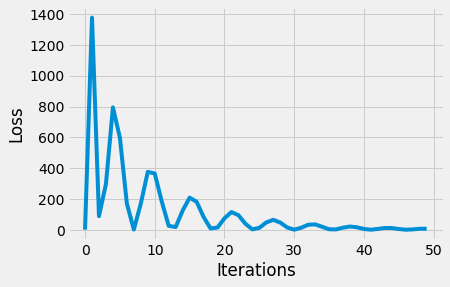

In [17]:
epochs = 50
outputs = []
losses = []
for epoch in range(epochs):
	
	# Output of Autoencoder
	reconstructed = ae(x)
	
	# Calculating the loss function
	loss = loss_function(reconstructed, x)
	
	# The gradients are set to zero,
	# the gradient is computed and stored.
	# .step() performs parameter update
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	
	# Storing the losses in a list for plotting
	losses.append(loss)
	outputs.append((epochs, x, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])


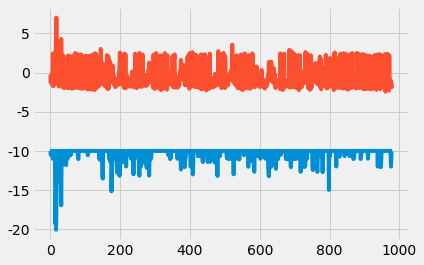

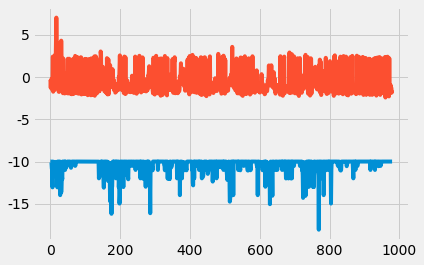

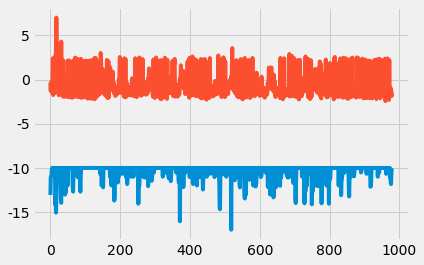

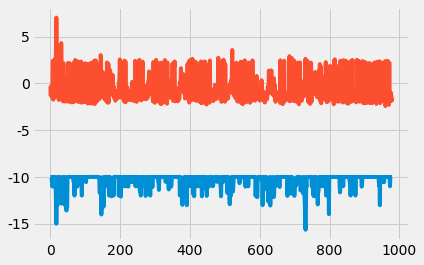

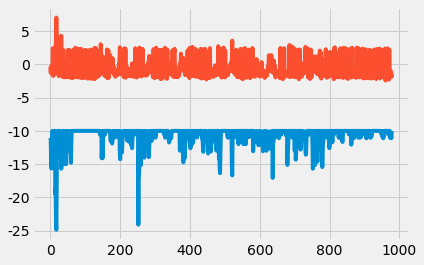

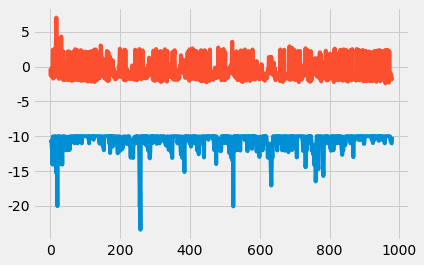

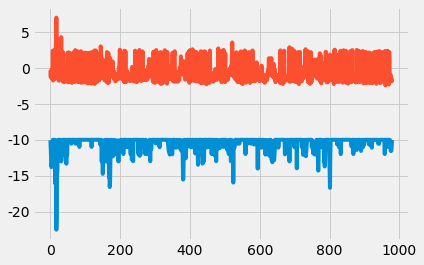

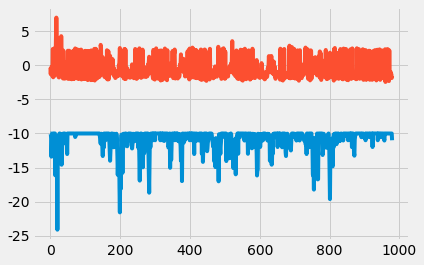

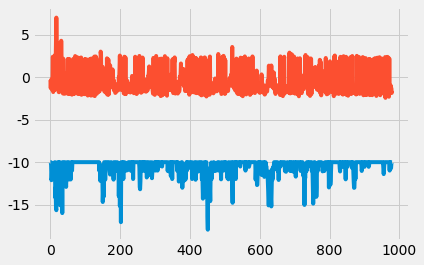

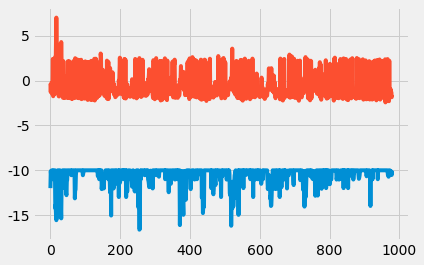

: 

In [18]:
xx=ae(x).detach().numpy()

for i in np.random.choice(list(range(9999)), 10):
    plt.plot(-x[i]-10)
    plt.plot(xx[i])
    plt.show()

In [18]:
compressedr=ae.encoder(x)
compressedr.shape

torch.Size([11331, 9])

## use task variables to predict compressed neural representation

In [20]:
x=together_normalized
y= compressedr.detach().numpy()
# Create a parameter grid with alpha values
param_grid = {'alpha': [ 0.1, 1.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)

Best alpha value: 1.0


In [21]:
pred = cross_val_predict(model, x, y, cv=5)

In [25]:
model.fit(x,y)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

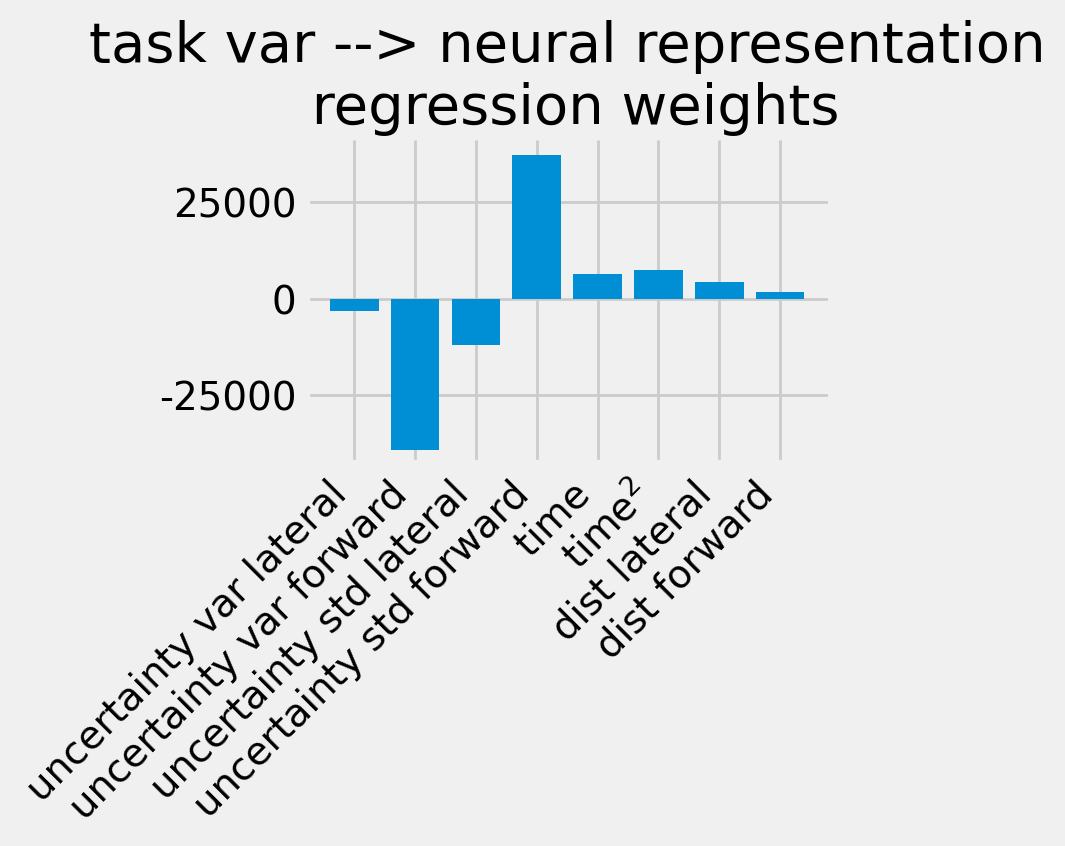

In [31]:
weights_=np.sum(model.coef_, axis=0)
with initiate_plot(3,2,200) as f:
    ax=f.add_subplot(111)
    plt.bar(list(range(len(weights_))),weights_.reshape(-1))
    quickspine(ax)
    ax.set_xticks(list(range(len(weights_))))
    ax.set_xticklabels(['uncertainty var lateral', 'uncertainty var forward','uncertainty std lateral', 'uncertainty std forward', 'time',r'$time^2$', 'dist lateral', 'dist forward' ],rotation=45, ha='right')
    plt.title('task var --> neural representation\n regression weights')

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


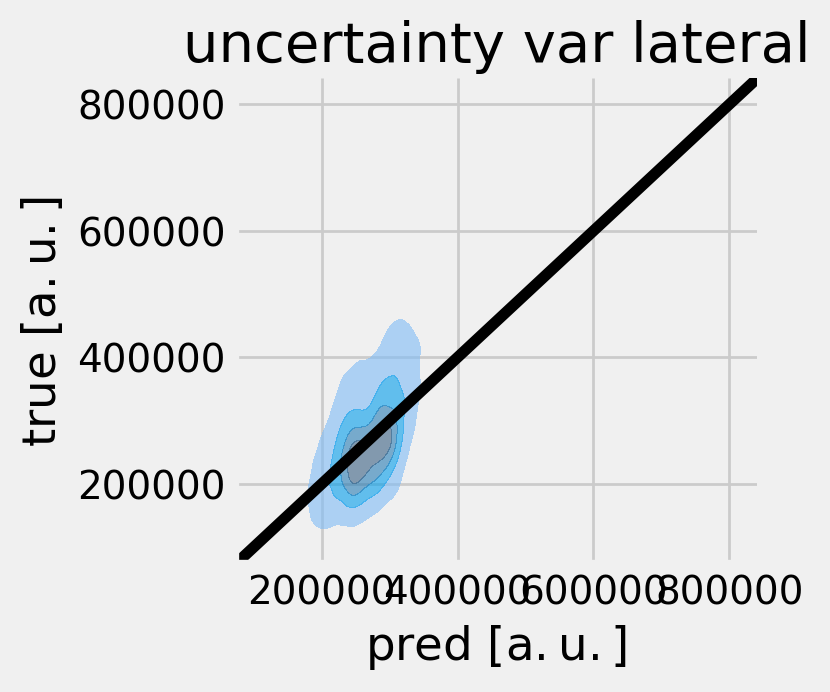

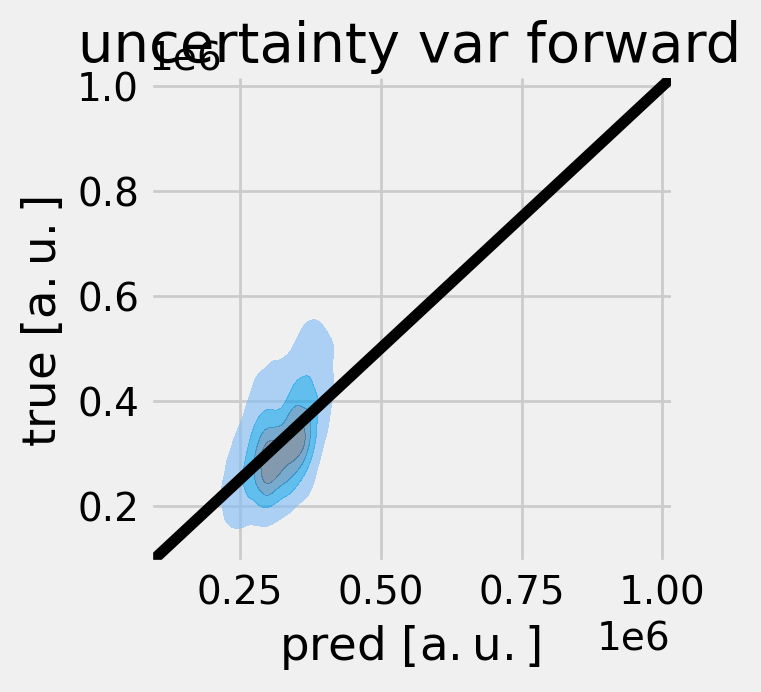

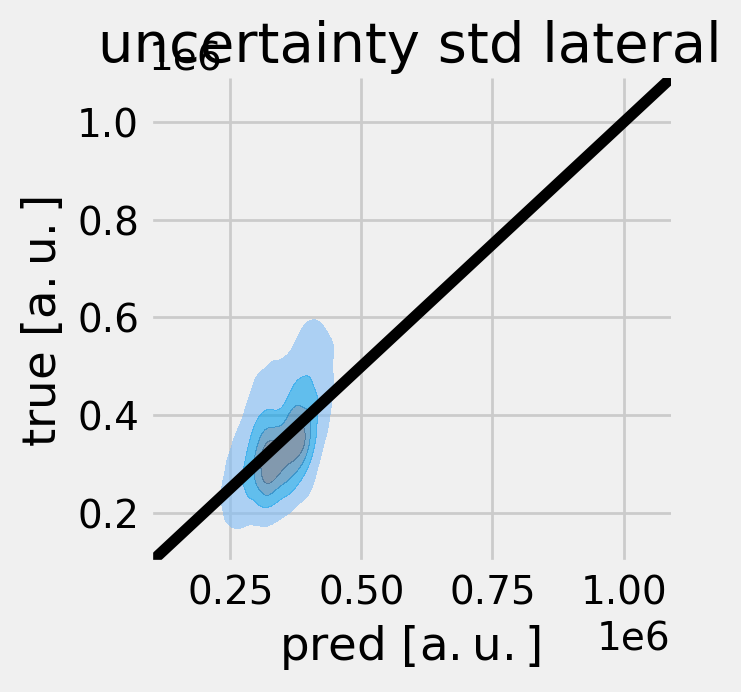

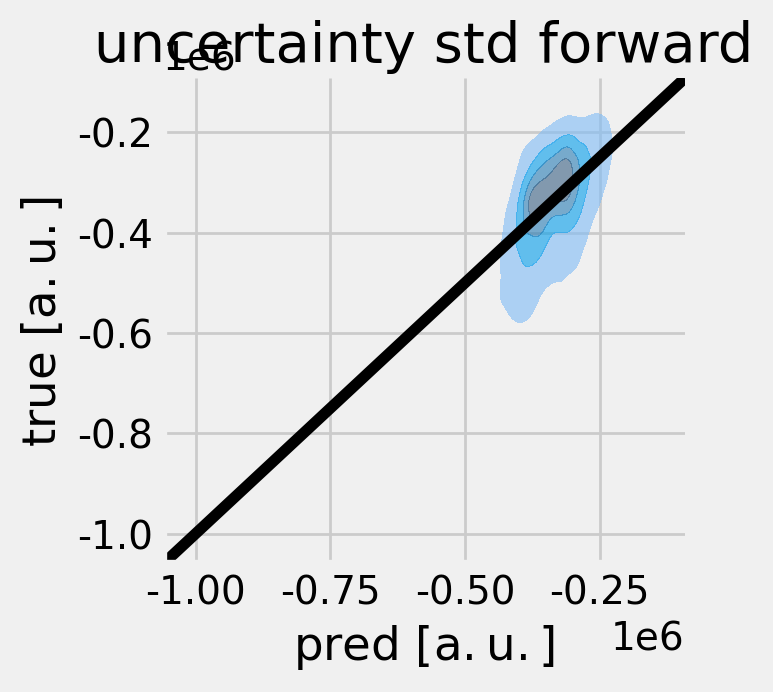

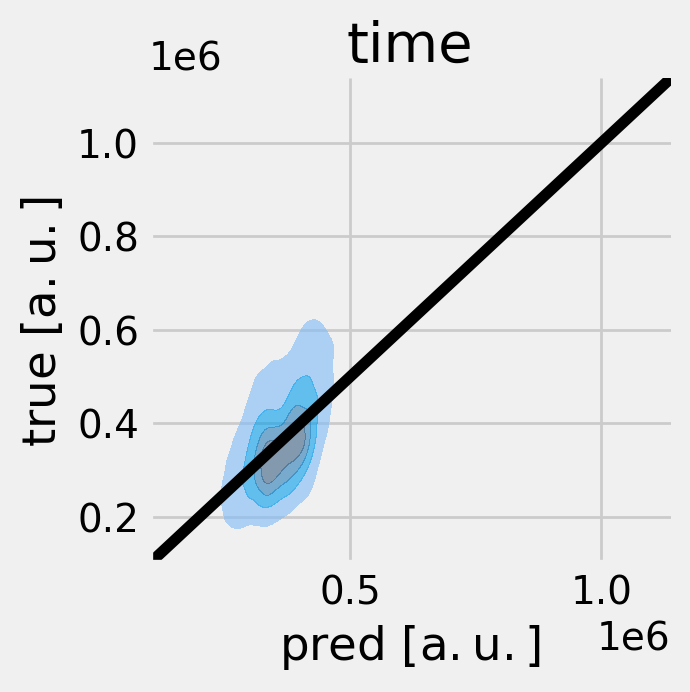

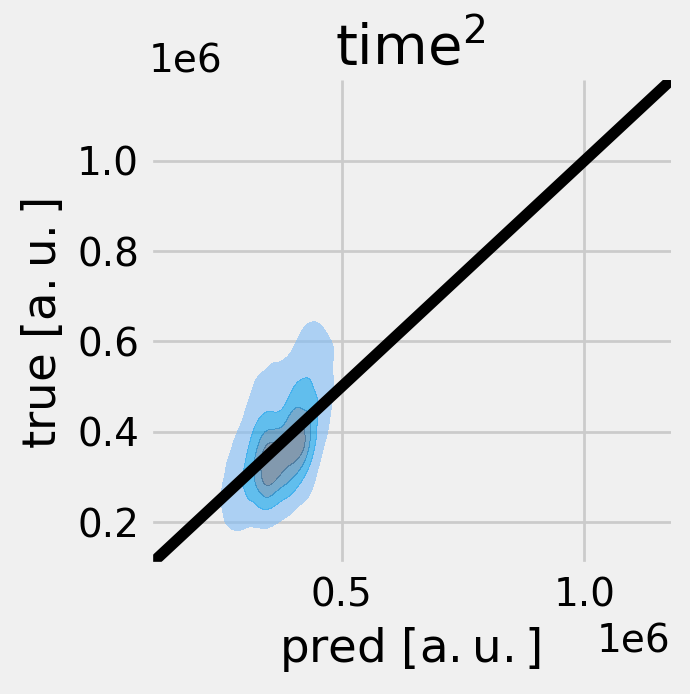

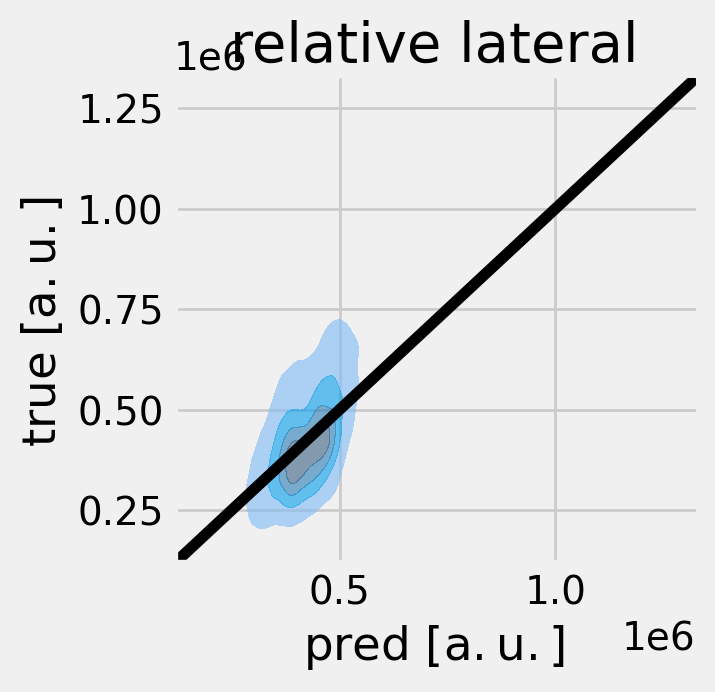

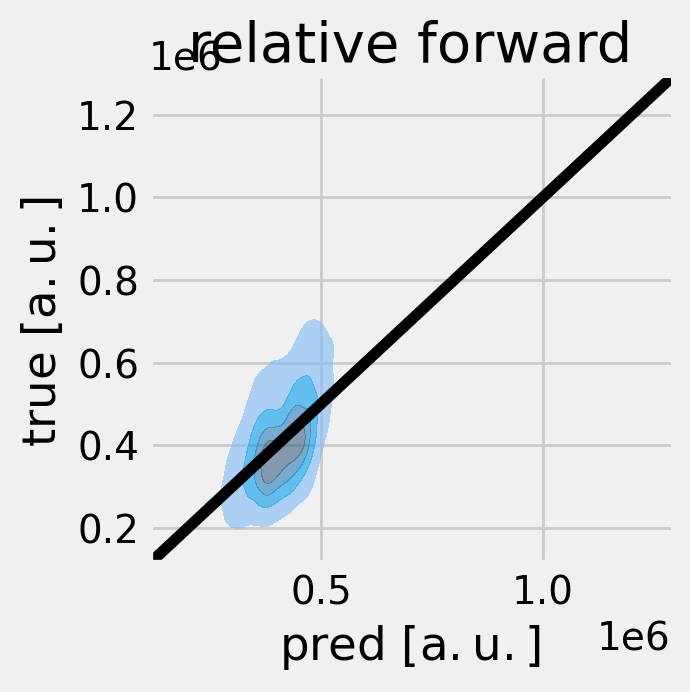

In [22]:
plot_pred(pred[:,0],y[:,0], title='uncertainty var lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,1], title='uncertainty var forward', unit=r'$a.u.$',every=1)
plot_pred(pred[:,2],y[:,2], title='uncertainty std lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,3],y[:,3], title='uncertainty std forward', unit=r'$a.u.$',every=1) 
plot_pred(pred[:,4],y[:,4], title='time', unit=r'$a.u.$',every=1)
plot_pred(pred[:,5],y[:,5], title=r'$time^2$', unit=r'$a.u.$',every=1)
plot_pred(pred[:,6],y[:,6], title='relative lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,7],y[:,7], title='relative forward', unit=r'$a.u.$',every=1) 